In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

In [2]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing, metrics, model_selection 
import pandas as pd

# Ajustar el tamaño predeterminado de las figuras
plt.rcParams['figure.figsize'] = [6,4]

In [3]:
df = pd.read_csv(DATOS_DIR + 'Iris.csv')

# Tomamos todas las columnas menos la última
X = np.array(df.iloc[:, 0:-1])
Y = np.array(df.iloc[:,-1])
encoder = preprocessing.LabelEncoder()
Y = encoder.fit_transform(Y)
Y_bin= to_categorical(Y)

In [4]:
#--- CONJUNTOS DE ENTRENAMIENTO Y TESTEO ---
X_train, X_test, Y_train, Y_test = model_selection.train_test_split( \
        X, Y_bin, test_size=0.20) #, random_state=42)


In [5]:
normalizarEntrada = 1  # 1 si normaliza; 0 si no

if normalizarEntrada:
    # Escala los valores entre 0 y 1
    min_max_scaler = preprocessing.StandardScaler()
    X_train = min_max_scaler.fit_transform(X_train)
    X_test = min_max_scaler.transform(X_test)

### Definición del modelo

In [6]:
# Crear un modelo de capas secuenciales
model=Sequential()

# Agregar las capas al modelo
model.add(Dense(2, input_shape=[4], activation='LeakyReLU'))
model.add(Dense(3, activation='softmax'))

# Imprimir un resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 10        
                                                                 
 dense_1 (Dense)             (None, 3)                 9         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Configuración para entrenamiento
model.compile(optimizer=SGD(learning_rate=0.1), loss='categorical_crossentropy', metrics='accuracy')

In [8]:
es = EarlyStopping(monitor='val_accuracy', patience=30, min_delta=1e-06, restore_best_weights=True)

H = model.fit(x = X_train, y = Y_train, epochs=4000, batch_size = 20, 
              validation_data = (X_test, Y_test),  callbacks=[es])

Epoch 1/4000
6/6 [==============================] - 1s 38ms/step - loss: 1.0958 - accuracy: 0.3417 - val_loss: 0.8640 - val_accuracy: 0.4667
Epoch 2/4000
6/6 [==============================] - 0s 6ms/step - loss: 0.7179 - accuracy: 0.6500 - val_loss: 0.7410 - val_accuracy: 0.5333
Epoch 3/4000
6/6 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6750 - val_loss: 0.6784 - val_accuracy: 0.5667
Epoch 4/4000
6/6 [==============================] - 0s 3ms/step - loss: 0.5797 - accuracy: 0.7167 - val_loss: 0.6359 - val_accuracy: 0.6667
Epoch 5/4000
6/6 [==============================] - 0s 4ms/step - loss: 0.5467 - accuracy: 0.7667 - val_loss: 0.6029 - val_accuracy: 0.7667
Epoch 6/4000
6/6 [==============================] - 0s 7ms/step - loss: 0.5215 - accuracy: 0.8417 - val_loss: 0.5764 - val_accuracy: 0.7333
Epoch 7/4000
6/6 [==============================] - 0s 7ms/step - loss: 0.5011 - accuracy: 0.8500 - val_loss: 0.5546 - val_accuracy: 0.8000
Epoch 8/4000
6/6 [=

In [9]:
print("épocas = %d" % len(H.history["val_accuracy"]))   
print("Epocas = %d" % es.stopped_epoch)

épocas = 41
Epocas = 40


In [10]:
# predecir la salida del modelo
Y_pred = model.predict(X_train)
Y_pred2 = np.argmax(Y_pred,axis=1)

Y_true =  np.argmax(Y_train,axis=1)

print("%% aciertos X_train : %.3f" % metrics.accuracy_score(Y_true, Y_pred2))

Y_test_pred = model.predict(X_test)
Y_test_pred2 = np.argmax(Y_test_pred,axis=1)

Y_test_true =  np.argmax(Y_test,axis=1)

print("%% aciertos X_train : %.3f" % metrics.accuracy_score(Y_test_true, Y_test_pred2))

4/4 [==============================] - 0s 2ms/step
% aciertos X_train : 0.875
1/1 [==============================] - 0s 16ms/step
% aciertos X_train : 0.933


In [11]:
report = metrics.classification_report(Y_true, Y_pred2)
print("Confusion matrix Training:\n%s" % report) 

MM = metrics.confusion_matrix(Y_true, Y_pred2)
print("Confusion matrix:\n%s" % MM)

Confusion matrix Training:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       0.93      0.68      0.79        41
           2       0.73      0.95      0.82        37

    accuracy                           0.88       120
   macro avg       0.89      0.88      0.87       120
weighted avg       0.89      0.88      0.87       120

Confusion matrix:
[[42  0  0]
 [ 0 28 13]
 [ 0  2 35]]


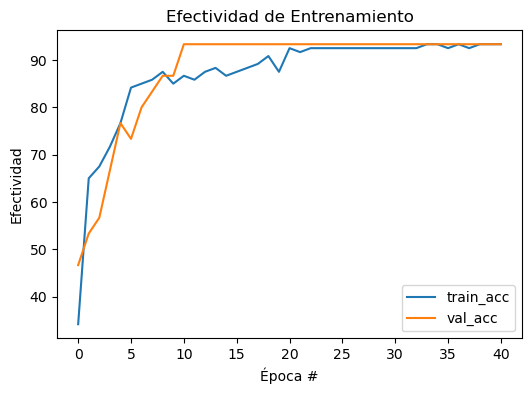

In [12]:
# dibuja accuracy del progreso del entrenamiento
accuracy = np.array(H.history["accuracy"])
val_accuracy = np.array(H.history["val_accuracy"])

N = np.arange(0, len(accuracy))
plt.figure()
#plt.plot(N, H.history["loss"], label="train_loss")
#plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, 100*accuracy, label="train_acc")
plt.plot(N, 100*val_accuracy, label="val_acc")
plt.title("Efectividad de Entrenamiento")
plt.xlabel("Época #")
plt.ylabel("Efectividad")
plt.legend(loc="lower right")

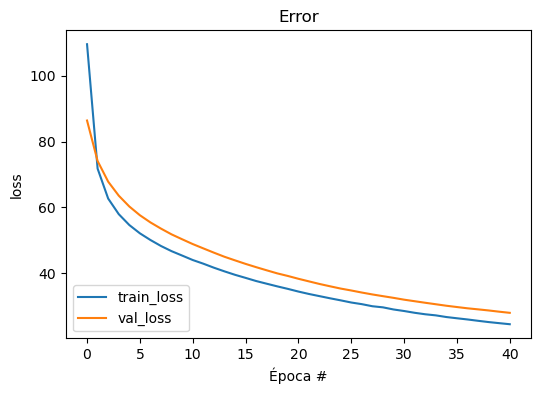

In [13]:
# dibuja accuracy del progreso del entrenamiento
accuracy = np.array(H.history["loss"])
val_accuracy = np.array(H.history["val_loss"])

N = np.arange(0, len(accuracy))
plt.figure()
#plt.plot(N, H.history["loss"], label="train_loss")
#plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, 100*accuracy, label="train_loss")
plt.plot(N, 100*val_accuracy, label="val_loss")
plt.title("Error")
plt.xlabel("Época #")
plt.ylabel("loss")
plt.legend(loc="lower left")